In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
# nltk.download('vader_lexicon')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
seed = 5

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline
sns.set(style="whitegrid", context='talk')

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd 
import numpy as np

In [ ]:
train_path = '/content/train.jsonl'
captions = []
for line in open(train_path, 'r'):
    captions.append(json.loads(line))
df_labels = pd.DataFrame(captions)

In [ ]:
df_labels.head()

In [ ]:
import json
train_path = '/content/face_race_boxes.json'
with open(train_path, 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data).T
df['fname'] = df.index
df['id']= df['fname'].apply(lambda x: x.split('.')[0])

df = pd.merge(on='id', how = 'inner',right=df, left = df_labels).head()
df.drop(columns = ['id','face_boxes','img'],inplace=True)

In [ ]:
df

,label,text,face_race,face_gender,fname
0,0,"everybody loves chocolate chip cookies, even h...",[White],[Female],82403.png
1,0,fine you're right. now can we fucking drop it?,[],[],76932.png
2,1,tattoos are bad for your health i know 5 milli...,[White],[Female],70914.png
3,1,jew mad? get fuhrerious!,[White],[Male],79351.png
4,0,voting for hillary is like letting casey antho...,"[White, Latino_Hispanic, White]","[Female, Female, Male]",79346.png


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=1000, random_state=seed, 
                                                    stratify=df['label'])



# Append sentiment back using indices
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [ ]:
print(f"Train: {train.shape[0]} rows and {train.shape[1]} columns")
print(f"{train['label'].value_counts()}\n")
# print(f"Test: {test.shape[0]} rows and {test.shape[1]} columns")
# print(test['label'].value_counts())

Train: 8500 rows and 2 columns
0    5481
1    3019
Name: label, dtype: int64

Test: 2000 rows and 2 columns
0    1250
1     750
Name: label, dtype: int64


‘VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.’

In [ ]:
sid = SentimentIntensityAnalyzer()
train[['neg', 'neu', 'pos', 'compound']] = train['text'].apply(sid.polarity_scores).apply(pd.Series)
train.head()

,text,label,neg,neu,pos,compound
0,its their character not their color that matters,0,0.000,0.864,0.136,0.0258
1,don't be afraid to love again everyone is not ...,0,0.129,0.613,0.258,0.4749
2,putting bows on your pet,0,0.000,1.000,0.000,0.0000
3,i love everything and everybody! except for sq...,0,0.244,0.461,0.296,0.2003
4,"everybody loves chocolate chip cookies, even h...",0,0.000,0.619,0.381,0.5719


neg, neu, pos: These three scores sum up to 1. These scores show the proportion of text falling in the category.
compound: This score ranges from -1 (the most negative) to 1 (the most positive.

In [ ]:
train.nlargest(5, ['pos'])

,text,label,neg,neu,pos,compound
7187,a natural beauty,0,0.0,0.000,1.000,0.7430
302,love is love respect,0,0.0,0.080,0.920,0.9100
7490,love is love respect,1,0.0,0.080,0.920,0.9100
7483,need a hug ? i love hugs,0,0.0,0.087,0.913,0.8885
5935,love is love,0,0.0,0.106,0.894,0.8555


In [ ]:
train.nlargest(5, ['neg'])

,text,label,neg,neu,pos,compound
2123,a tragedy,0,1.000,0.000,0.0,-0.6597
4842,no racism,0,1.000,0.000,0.0,-0.7430
5107,no racism,0,1.000,0.000,0.0,-0.7430
8330,haters,0,1.000,0.000,0.0,-0.4939
5240,remember no faggot,1,0.868,0.132,0.0,-0.7650


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


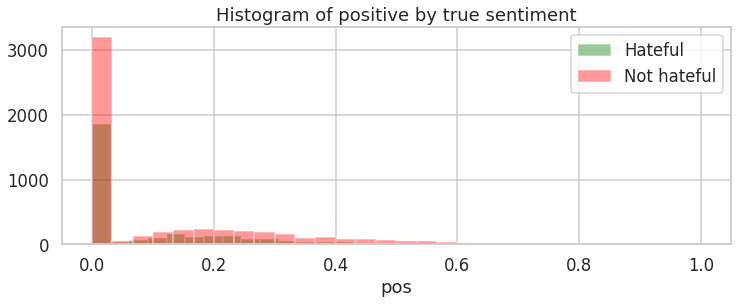

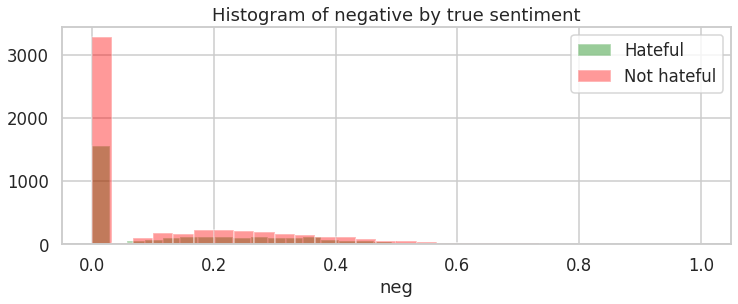

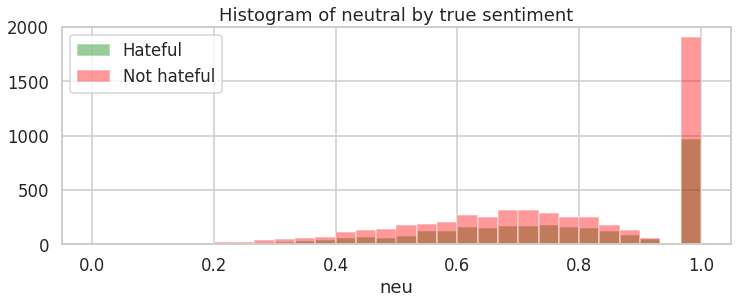

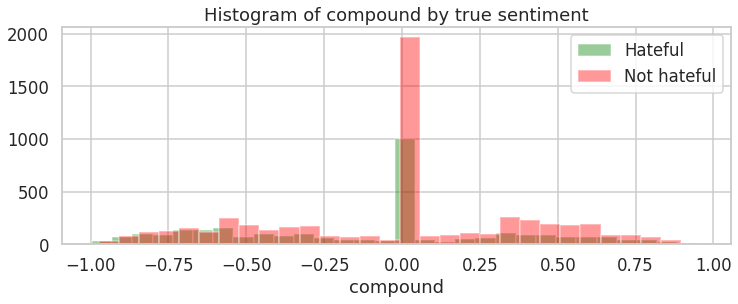

In [ ]:
hm = {'pos':'positive',
      'neg':'negative',
      'neu':'neutral',
      'compound':'compound'
      }
for var in ['pos', 'neg', 'neu', 'compound']:
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("label==1")[var], bins=30, kde=False,  color='green', label='Hateful')
    sns.distplot(train.query("label==0")[var], bins=30, kde=False,  color='red', label='Not hateful')
    plt.legend()
    plt.title(f'Histogram of {hm[var]} by true sentiment');

In [ ]:
train['vader_polarity'] = np.where(train['pos']>train['neg'], 1, 0)
target_names=['negative', 'positive']
print(classification_report(train['label'], 
                            train['vader_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.62      0.68      0.65      5481
    positive       0.31      0.26      0.28      3019

    accuracy                           0.53      8500
   macro avg       0.47      0.47      0.47      8500
weighted avg       0.51      0.53      0.52      8500



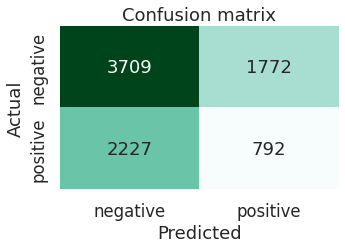

In [ ]:
# Create function so that we could reuse later
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});
# Plot confusion matrix
plot_cm(train['label'], train['vader_polarity'])

In [ ]:
train['vader_compound'] = np.where(train['compound']>0, 1, 0)
print(classification_report(train['label'], 
                            train['vader_compound'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.62      0.68      0.65      5481
    positive       0.31      0.26      0.28      3019

    accuracy                           0.53      8500
   macro avg       0.47      0.47      0.47      8500
weighted avg       0.51      0.53      0.52      8500



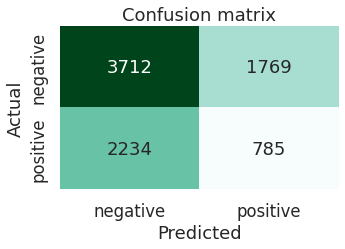

In [ ]:
plot_cm(train['label'], train['vader_compound'])

polarity: ranges from -1 (the most negative) to 1 (the most positive)
subjectivity: ranges from 0 (very objective) to 1 (very subjective)

In [ ]:
train[['polarity', 'subjectivity']] = train['text'].apply(lambda x:TextBlob(x).sentiment).to_list()
columns = ['text', 'label', 'polarity', 'subjectivity']
train[columns].nlargest(5, ['polarity'])

,text,label,polarity,subjectivity
5,go sports! do the thing! win the points!,0,1.0,0.4
488,my dad is the best at hide and seek he's been ...,1,1.0,0.3
579,dressed for sundays best,0,1.0,0.3
603,i'm awesome on the piano but i suck at singing,0,1.0,1.0
691,make the best out of what you have,0,1.0,0.3


In [ ]:
train[columns].nsmallest(5, ['polarity'])

,text,label,polarity,subjectivity
459,you ever get laid in a sleeping bag? it's awfu...,0,-1.0,1.0
926,worst pijama party ever,0,-1.0,1.0
1203,ever notice that everything deemed evil by god...,0,-1.0,1.0
1295,but dad please respect the rights of trans kid...,1,-1.0,0.9
1771,we can never undo the horrible acts he has com...,0,-1.0,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


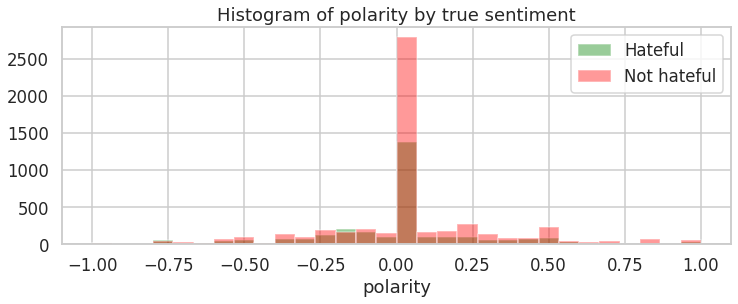

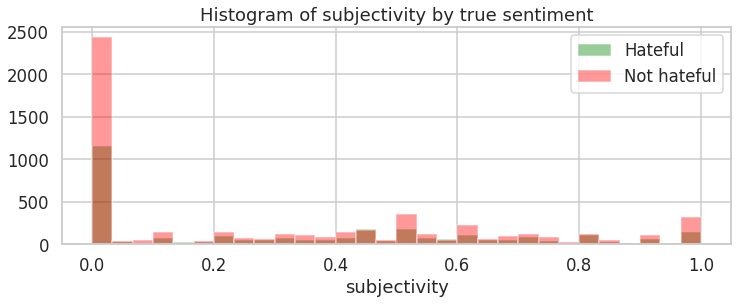

In [ ]:
for var in ['polarity', 'subjectivity']:
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("label==1")[var], bins=30, kde=False, 
                 color='green', label='Hateful')
    sns.distplot(train.query("label==0")[var], bins=30, kde=False, 
                 color='red', label='Not hateful')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

In [ ]:
train['blob_polarity'] = np.where(train['polarity']>0, 1, 0)
print(classification_report(train['label'], 
                            train['blob_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.64      0.72      0.68      5481
    positive       0.33      0.25      0.28      3019

    accuracy                           0.55      8500
   macro avg       0.48      0.48      0.48      8500
weighted avg       0.53      0.55      0.54      8500



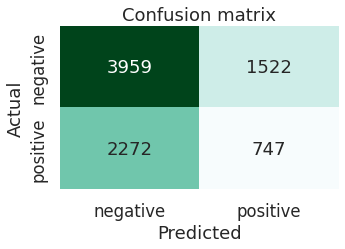

In [ ]:
plot_cm(train['label'], train['blob_polarity'])

In [ ]:
pd.crosstab(train['vader_polarity'], train['blob_polarity'])

blob_polarity,0,1
vader_polarity,,
0,4946,990
1,1285,1279


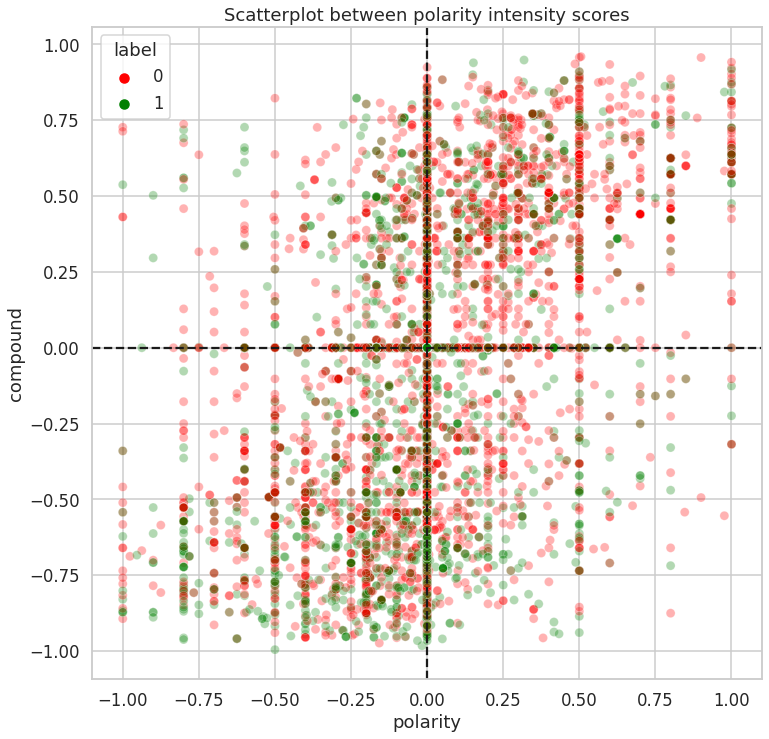

In [ ]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=train, x='polarity', y='compound',
                hue='label', palette=['red', 'green'], 
                alpha=.3)
plt.axhline(0, linestyle='--', color='k')
plt.axvline(0, linestyle='--', color='k')
plt.title('Scatterplot between polarity intensity scores');

In [ ]:
# Define functions
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('log', LogisticRegression(random_state=seed, 
                                             max_iter=1000)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('mnb', MultinomialNB()))
    return models
def assess(X, y, models, cv=5, scoring=['roc_auc', 
                                        'accuracy', 
                                        'f1']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                             scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [ ]:
models = create_baseline_models()
models

[('log', LogisticRegression(max_iter=1000, random_state=5)),
 ('sgd', SGDClassifier(random_state=5)),
 ('mnb', MultinomialNB())]

In [ ]:
vectoriser = TfidfVectorizer(token_pattern=r'[a-z]+', 
                             stop_words='english', 
                             min_df=30, 
                             max_df=.7)
X_train_simpler = vectoriser.fit_transform(X_train)
# Assess the model
assess(X_train_simpler, y_train, models)

,log,sgd,mnb
fit_time_mean,0.078838,0.013302,0.002862
fit_time_std,0.005754,0.001307,0.000109
score_time_mean,0.003551,0.003435,0.004031
score_time_std,0.000135,0.000148,0.000121
test_accuracy_mean,0.711059,0.717059,0.691059
test_accuracy_std,0.016052,0.015003,0.015874
test_f1_mean,0.474915,0.503895,0.381510
test_f1_std,0.025210,0.028939,0.032382
test_roc_auc_mean,0.708361,0.701794,0.687002
test_roc_auc_std,0.019580,0.026207,0.017089


In [ ]:
# Define function
def preprocess_text(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') 
              for t in tokens]
    return tokens
# Preprocess the data
vectoriser = TfidfVectorizer(analyzer=preprocess_text, 
                             min_df=30, 
                             max_df=.7)
X_train_simple = vectoriser.fit_transform(X_train)
# Assess models
assess(X_train_simple, y_train, models)

,log,sgd,mnb
fit_time_mean,0.078664,0.014756,0.003002
fit_time_std,0.011891,0.001143,0.000230
score_time_mean,0.003612,0.003430,0.003852
score_time_std,0.000127,0.000072,0.000375
test_accuracy_mean,0.709765,0.719765,0.687647
test_accuracy_std,0.016858,0.017670,0.011399
test_f1_mean,0.462329,0.490058,0.324191
test_f1_std,0.035252,0.037611,0.032099
test_roc_auc_mean,0.705240,0.709495,0.690670
test_roc_auc_std,0.020721,0.021064,0.018239


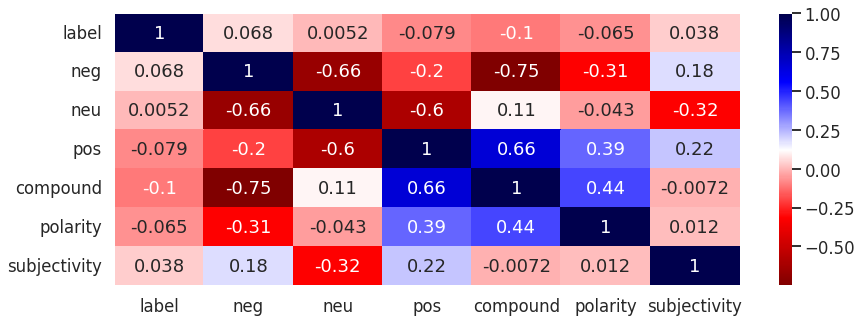

In [ ]:
plt.figure(figsize = (14,5))
columns = ['label', 'neg', 'neu', 'pos', 'compound', 'polarity', 
           'subjectivity']
sns.heatmap(train[columns].corr(), annot=True, cmap='seismic_r');

In [ ]:
# Initialise a model
sgd = SGDClassifier(random_state=seed)
# Initialise a scaler
scaler = MinMaxScaler()
# Assess the model using scores
scores = train[['neg', 'neu', 'pos', 'compound', 'polarity', 
                'subjectivity']]
assess(scaler.fit_transform(scores), y_train, [('sgd', sgd)])

,sgd
fit_time_mean,0.025597
fit_time_std,0.004110
score_time_mean,0.006346
score_time_std,0.002839
test_accuracy_mean,0.644824
test_accuracy_std,0.000263
test_f1_mean,0.000000
test_f1_std,0.000000
test_roc_auc_mean,0.535065
test_roc_auc_std,0.030789


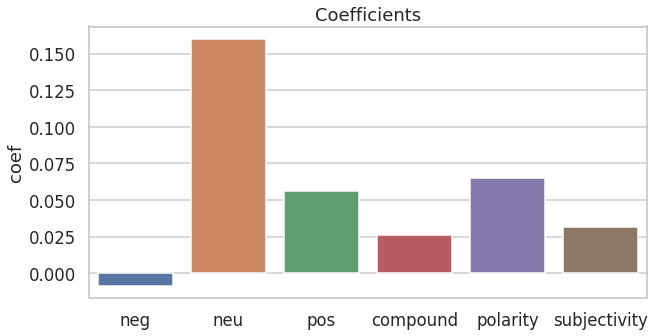

In [ ]:
# Fit to training data
sgd.fit(scores, y_train)
# Get coefficients
coefs = pd.DataFrame(data=sgd.coef_, columns=scores.columns).T
coefs.rename(columns={0: 'coef'}, inplace=True)
# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=coefs.index, y='coef', data=coefs)
plt.title('Coefficients');

In [ ]:
# Add features to sparse matrix
selected_scores = train[['neg', 'neu','pos', 'polarity','subjectivity','compound']]
X_train_extended = hstack([X_train_simpler, csr_matrix(scaler.fit_transform(selected_scores))])
# Assess
assess(X_train_extended, y_train, [('sgd', sgd)])

,sgd
fit_time_mean,0.024173
fit_time_std,0.002920
score_time_mean,0.003761
score_time_std,0.000216
test_accuracy_mean,0.718235
test_accuracy_std,0.014852
test_f1_mean,0.502007
test_f1_std,0.029140
test_roc_auc_mean,0.709673
test_roc_auc_std,0.018857


In [ ]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+')),
                 ('model', SGDClassifier(random_state=seed))])
# Prepare a random search
param_distributions = {'vectoriser__min_df': np.arange(10, 1000, 10),
                       'vectoriser__max_df': np.linspace(.2, 1, 40),
                       'model__loss': ['log', 'hinge']}
r_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=seed)
r_search.fit(X_train, y_train)
# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
columns = [col for col in r_search_results.columns 
           if re.search(r"split|param_", col)]
r_summary = r_search_results[columns].copy()
r_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in r_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in r_summary.columns ]
r_summary.columns = columns
r_summary.head()

,min_df,max_df,loss,split0,split1,split2,split3,split4
11,30,0.610256,log,0.718824,0.690588,0.696471,0.694706,0.711176
20,130,0.220513,hinge,0.697059,0.684706,0.684706,0.670000,0.694118
24,80,0.241026,log,0.683529,0.689412,0.677647,0.672941,0.687647
19,140,0.528205,hinge,0.687647,0.681765,0.684706,0.668824,0.682941
2,210,0.220513,hinge,0.677059,0.669412,0.667059,0.661765,0.667647


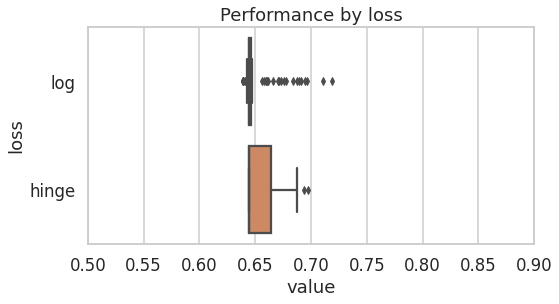

In [ ]:
r_summary_long = pd.melt(r_summary, 
                         id_vars=['min_df', 
                                  'max_df', 
                                  'loss'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
# Plot hyperparameter 'loss'
plt.figure(figsize=(8,4))
plt.title('Performance by loss')
sns.boxplot(x='value', y='loss', data=r_summary_long, 
            orient='h')
plt.xlim(.5, .9);

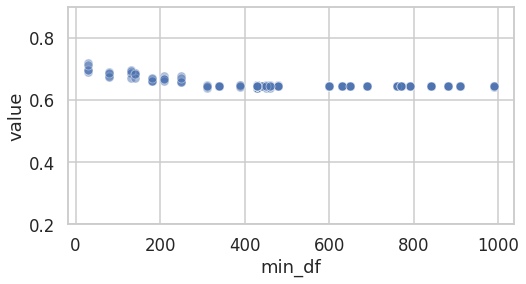

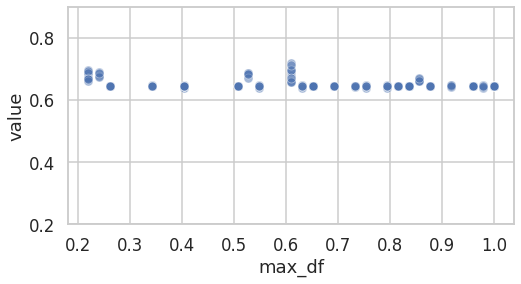

In [ ]:
for param in ['min_df', 'max_df']:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=param, y="value", data=r_summary_long, 
                    x_jitter=True, alpha=0.5)
    plt.ylim(.2, .9);

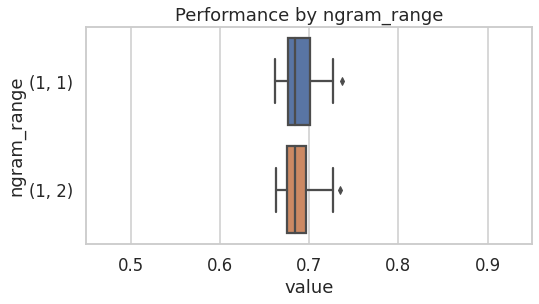

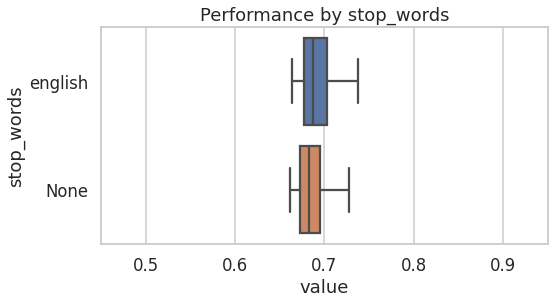

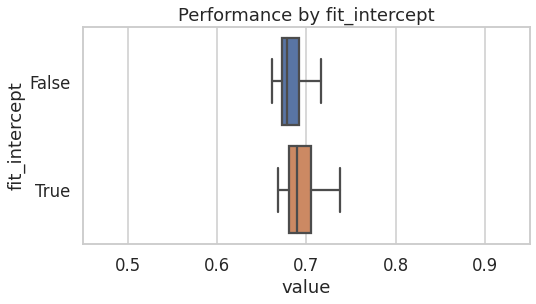

In [ ]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', max_df=.6)),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])
# Prepare a grid search
param_grid = {'vectoriser__min_df': [30, 90, 150],
              'vectoriser__ngram_range': [(1,1), (1,2)],
              'vectoriser__stop_words': [None, 'english'],
              'model__fit_intercept': [True, False]}
g_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1)
g_search.fit(X_train, y_train)
# Save results to a dataframe
g_search_results = pd.DataFrame(g_search.cv_results_).sort_values(by='rank_test_score')

columns = [col for col in g_search_results.columns 
           if re.search(r"split|param_", col)]
g_summary = g_search_results[columns+['mean_test_score']].copy()
g_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in g_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in g_summary.columns ]
g_summary.columns = columns
g_summary.head()

# Create a long dataframe
g_summary_long = pd.melt(g_summary, 
                         id_vars=['min_df', 
                                  'ngram_range', 
                                  'stop_words', 
                                  'fit_intercept'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
g_summary_long.replace({None: 'None'}, inplace=True)
# Plot performance
for param in ['ngram_range', 'stop_words', 'fit_intercept']:
    plt.figure(figsize=(8,4))
    plt.title(f'Performance by {param}')
    sns.boxplot(x='value', y=param, data=g_summary_long, orient='h')
    plt.xlim(.45, .95);

In [ ]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', min_df=30, max_df=.6, ngram_range=(1,2))),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.6, min_df=30, ngram_range=(1, 2),
                                 token_pattern='[a-z]+')),
                ('model', SGDClassifier(random_state=5))])

In [ ]:
coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())
coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')
coefs

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,coef
doing,-1.149496
house,-1.071177
in a,-0.989156
of my,-0.918702
guns,-0.860750
...,...
transgender,4.256454
gay,4.300187
muslims,4.563343
black,4.624344


              precision    recall  f1-score   support

    negative       0.91      0.65      0.76      1755
    positive       0.18      0.55      0.27       245

    accuracy                           0.64      2000
   macro avg       0.54      0.60      0.51      2000
weighted avg       0.82      0.64      0.70      2000

1000 loops, best of 5: 756 µs per loop
1000 loops, best of 5: 1.06 ms per loop
1000 loops, best of 5: 913 µs per loop
1000 loops, best of 5: 965 µs per loop
1000 loops, best of 5: 728 µs per loop
1000 loops, best of 5: 719 µs per loop
1000 loops, best of 5: 925 µs per loop
1000 loops, best of 5: 979 µs per loop
1000 loops, best of 5: 1.06 ms per loop
100 loops, best of 5: 1.59 ms per loop


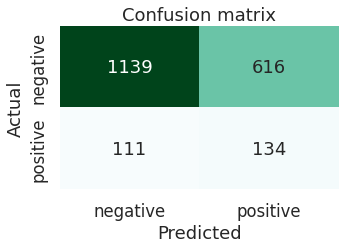

In [ ]:
test_unseen_path = '/content/drive/MyDrive/AHATEFULMEME/root/data/hateful_memes/test_unseen.jsonl'
test_unseen_data = []
for line in open(test_unseen_path, 'r'):
    test_unseen_data.append(json.loads(line))
test_unseen_df = pd.DataFrame(test_unseen_data)
X_test_unseen, y_test_unseen = test_unseen_df['text'], test_unseen_df['label']


test_pred = pipe.predict(X_test_unseen)
print(classification_report(test_pred, 
                            y_test_unseen, 
                            target_names=target_names))

plot_cm(test_pred, y_test_unseen, target_names=target_names)

for i in range(10):
    lead = X_test_unseen.sample(1)
    %timeit pipe.predict(lead)

              precision    recall  f1-score   support

    negative       0.92      0.55      0.69       852
    positive       0.21      0.71      0.33       148

    accuracy                           0.57      1000
   macro avg       0.56      0.63      0.51      1000
weighted avg       0.81      0.57      0.63      1000

1000 loops, best of 5: 774 µs per loop
1000 loops, best of 5: 752 µs per loop
1000 loops, best of 5: 779 µs per loop
1000 loops, best of 5: 748 µs per loop
1000 loops, best of 5: 739 µs per loop
1000 loops, best of 5: 737 µs per loop
1000 loops, best of 5: 737 µs per loop
1000 loops, best of 5: 1.05 ms per loop
1000 loops, best of 5: 1.26 ms per loop
1000 loops, best of 5: 1.25 ms per loop


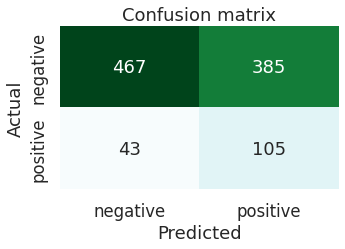

In [ ]:
test_seen_path = '/content/drive/MyDrive/AHATEFULMEME/root/data/hateful_memes/test_seen.jsonl'
test_seen_data = []
for line in open(test_seen_path, 'r'):
    test_seen_data.append(json.loads(line))
test_seen_df = pd.DataFrame(test_seen_data)
X_test_seen, y_test_seen = test_seen_df['text'], test_seen_df['label']


test_pred_seen = pipe.predict(X_test_seen)
print(classification_report(test_pred_seen, 
                            y_test_seen, 
                            target_names=target_names))

plot_cm(test_pred_seen, y_test_seen, target_names=target_names)

for i in range(10):
    lead = X_test_seen.sample(1)
    %timeit pipe.predict(lead)